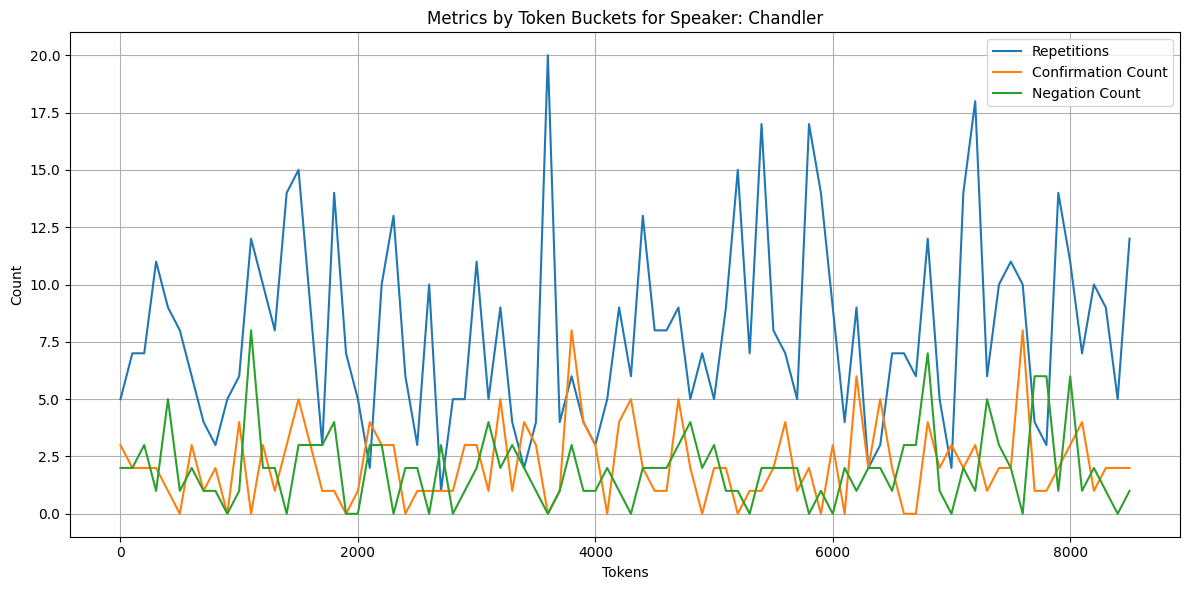

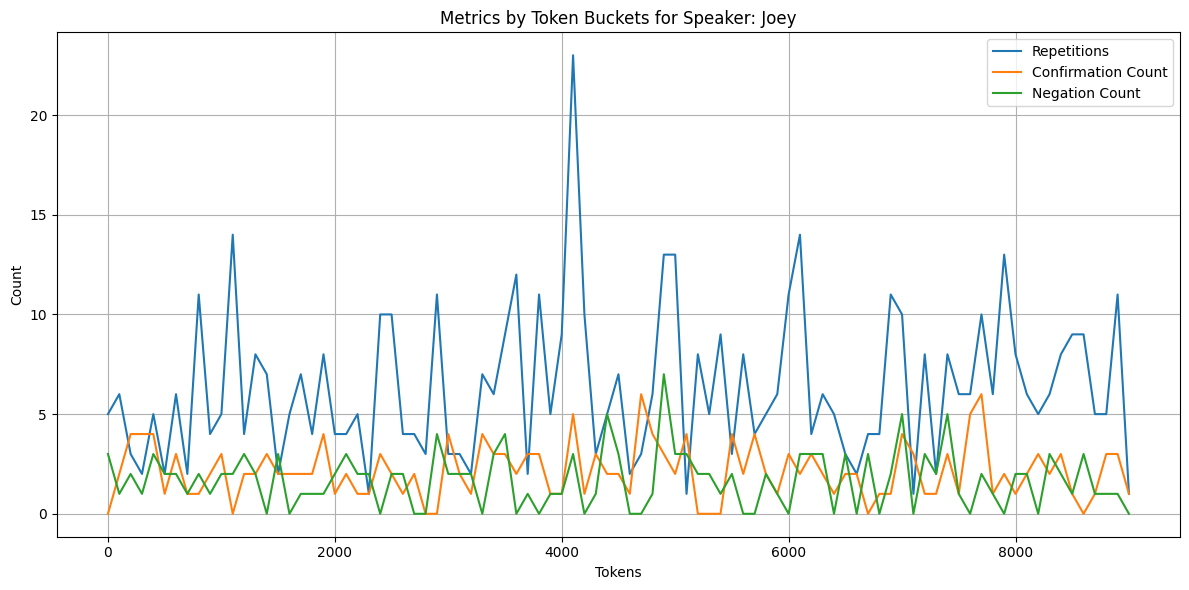

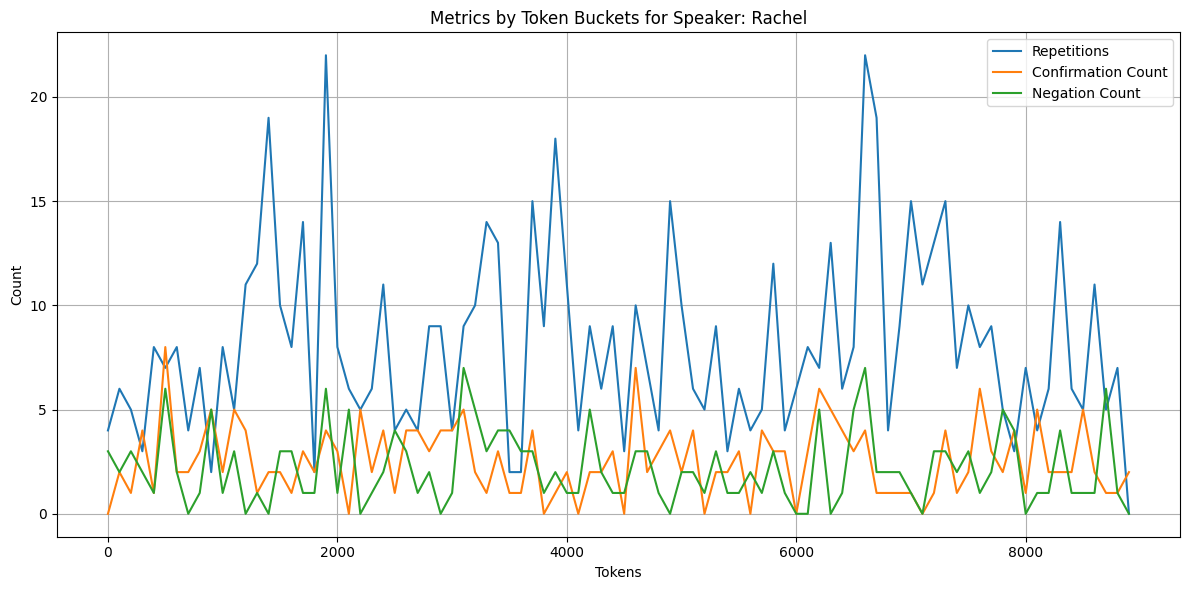

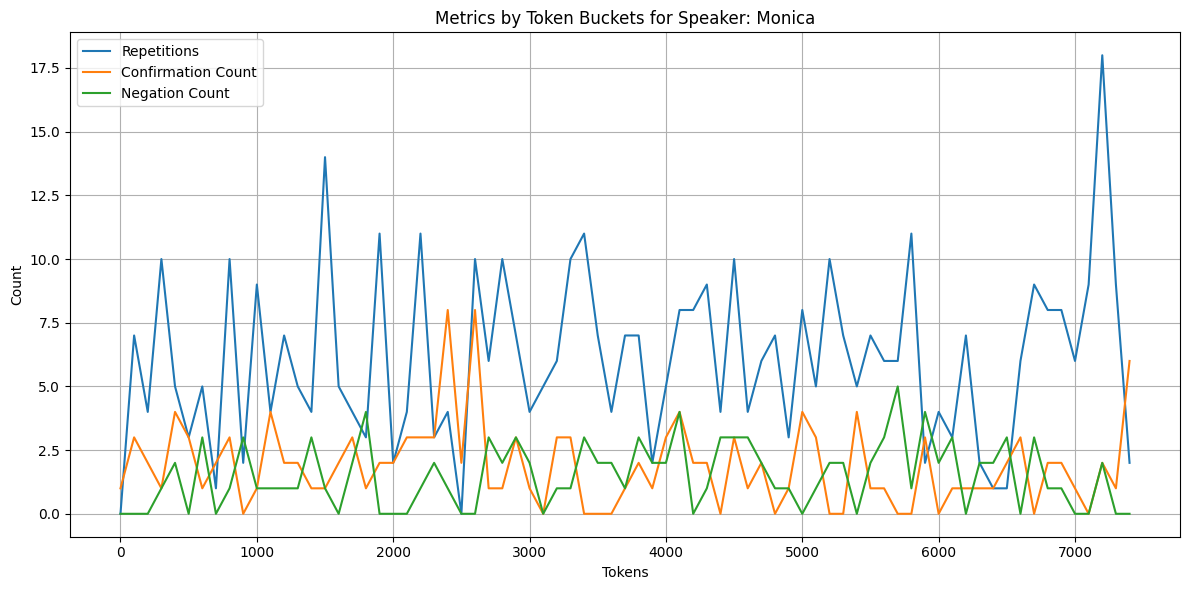

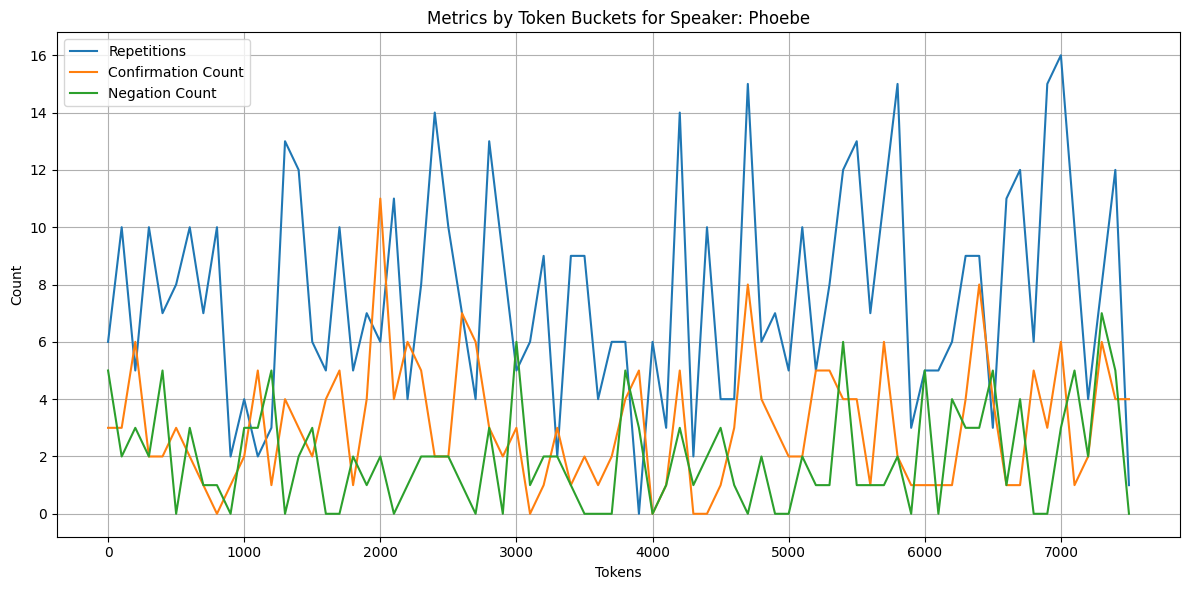

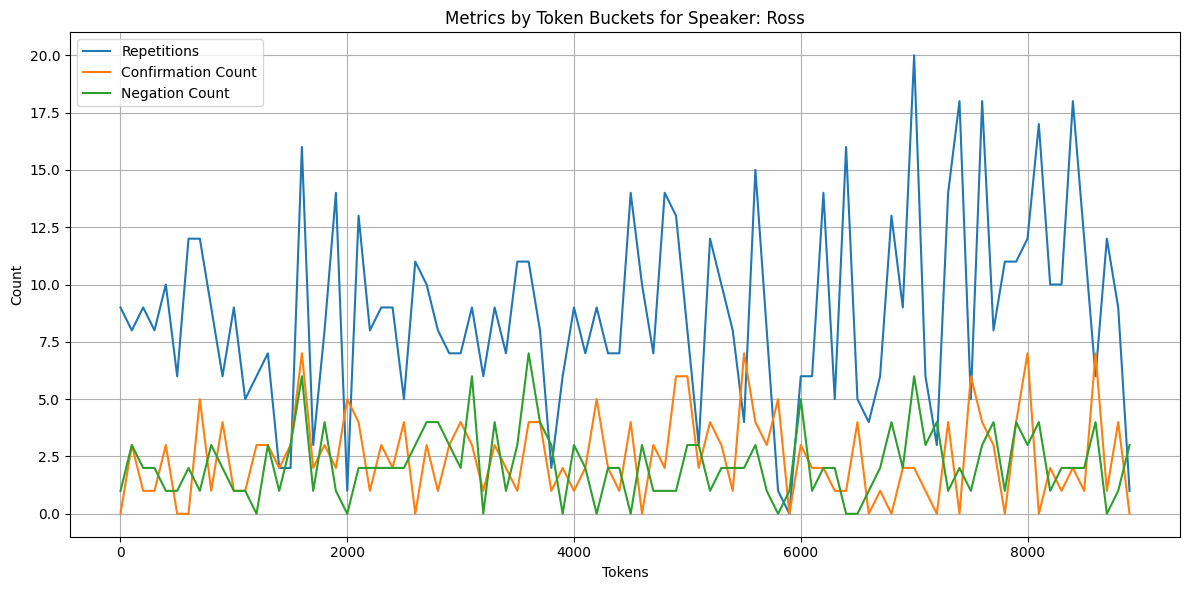

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np

# Define your words sets
confirmation_words = {'yes', 'yeah', 'yep', 'okay', 'alright', 'sure', 'absolutely', 'certainly', 'of course', 'indeed', 'definitely'}
negation_words = {'no', 'not', 'never', 'none', 'nor', 'nobody', 'neither', "don't", "isn't", "wasn't", "weren't", "doesn't", "won't", "haven't"}
stop_words = {'the', 'a', 't', 's', 'to', 'is', 'and'}

def preprocess(tokens):
    return [
        token.translate(str.maketrans('', '', string.punctuation)).lower()
        for token in tokens if token not in stop_words
    ]

def calculate_row_metrics(speaker_df):
    # Metrics per row
    all_tokens = []
    token_sizes = []
    repetitions = []
    confirmation_counts = []
    negation_counts = []

    for _, row in speaker_df.iterrows():
        tokens = row['Utterance_1'].split()
        tokens = preprocess(tokens)
        all_tokens.append(tokens)

        # Token size
        token_size = len(tokens)
        token_sizes.append(token_size)

        # Word counts
        word_counts = Counter(tokens)
        
        # Calculations
        repetition_count = sum(count - 1 for word, count in word_counts.items() if count > 1)
        repetitions.append(repetition_count)

        confirmation_count = sum(count for word, count in word_counts.items() if word in confirmation_words)
        confirmation_counts.append(confirmation_count)

        negation_count = sum(count for word, count in word_counts.items() if word in negation_words)
        negation_counts.append(negation_count)

    speaker_df['Tokens'] = all_tokens
    speaker_df['Token Size'] = token_sizes
    speaker_df['Repetitions'] = repetitions
    speaker_df['Confirmation Count'] = confirmation_counts
    speaker_df['Negation Count'] = negation_counts

    return speaker_df

def calculate_bucket_metrics(speaker_df, bucket_size=100):
    # Cumulative token counter
    cumulative_tokens = 0
    bucket_metrics = {
        'Bucket': [],
        'Repetitions': [],
        'Confirmation Count': [],
        'Negation Count': []
    }
    
    current_bucket = 0
    bucket_repetitions = 0
    bucket_confirmations = 0
    bucket_negations = 0

    for _, row in speaker_df.iterrows():
        # Get counts for this utterance
        token_size = row['Token Size']
        cumulative_tokens += token_size

        # If we're in the same bucket, keep adding
        while cumulative_tokens > (current_bucket + 1) * bucket_size:
            # Save current bucket metrics
            bucket_metrics['Bucket'].append(current_bucket * bucket_size)
            bucket_metrics['Repetitions'].append(bucket_repetitions)
            bucket_metrics['Confirmation Count'].append(bucket_confirmations)
            bucket_metrics['Negation Count'].append(bucket_negations)
            
            # Reset metrics for the next bucket
            current_bucket += 1
            bucket_repetitions = 0
            bucket_confirmations = 0
            bucket_negations = 0

        # Add current row metrics to current bucket
        bucket_repetitions += row['Repetitions']
        bucket_confirmations += row['Confirmation Count']
        bucket_negations += row['Negation Count']

    # Add last bucket if not empty
    if bucket_repetitions > 0 or bucket_confirmations > 0 or bucket_negations > 0:
        bucket_metrics['Bucket'].append(current_bucket * bucket_size)
        bucket_metrics['Repetitions'].append(bucket_repetitions)
        bucket_metrics['Confirmation Count'].append(bucket_confirmations)
        bucket_metrics['Negation Count'].append(bucket_negations)
    
    return pd.DataFrame(bucket_metrics)

def calculate_metrics(speaker_df):

    tokens = [token for sublist in speaker_df['Tokens'].values for token in sublist]
    total_tokens = len(tokens)
    
    vocabulary_set = set(tokens)
    vocabulary_size = len(vocabulary_set)

    total_repetitions = sum(speaker_df['Repetitions'].values)
    total_confirmations = sum(speaker_df['Confirmation Count'].values)
    total_negations = sum(speaker_df['Negation Count'].values)
    
    metrics = {}
    metrics['Vocabulary Size'] = vocabulary_size
    metrics['Total Tokens'] = total_tokens
    metrics['Total Repetitions'] = total_repetitions
    metrics['Total Confirmations'] = total_confirmations
    metrics['Total Negations'] = total_negations
    
    return metrics

def calculate_average_personality(speaker_df):
    personality_columns = ['Personality']
    averages = {trait: eval(speaker_df[trait].iloc[0]) for trait in personality_columns}
    return averages

# Load your data
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)

# Create a dictionary of DataFrames with each subset being a copy of the relevant data
speakers = df['Speaker_1'].unique()
speaker_dfs = {speaker: df[df['Speaker_1'] == speaker].copy() for speaker in speakers}

all_metrics = {}
all_personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in speaker_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_metrics = pd.DataFrame(all_metrics).T

In [36]:
df_metrics

,Vocabulary Size,Total Tokens,Total Repetitions,Total Confirmations,Total Negations
Chandler,1620,8587,679,186,169
Joey,1621,9018,576,194,154
Rachel,1429,8923,733,229,195
Monica,1492,7448,457,141,112
Phoebe,1479,7511,576,233,149
Ross,1557,8961,789,222,196


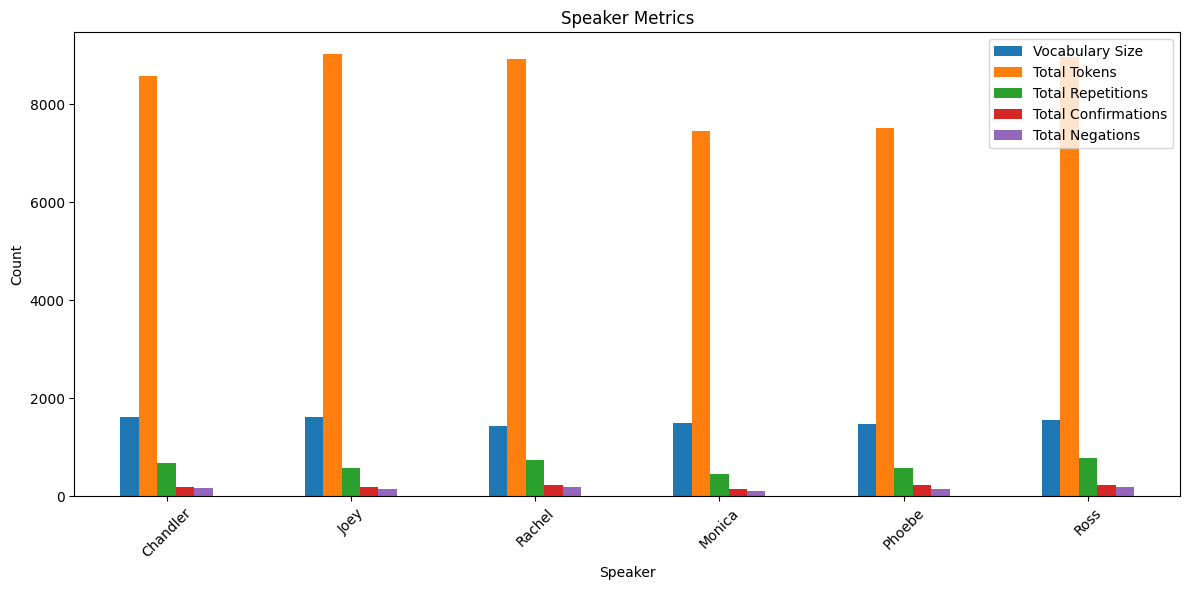

In [37]:
df_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Speaker Metrics')
plt.ylabel('Count')
plt.xlabel('Speaker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task 4
In Task 4, we focus on segmenting the dataset according to the dominant personality trait of each speaker. This segmentation process allows us to analyze language patterns specific to each personality type within the OCEAN model—Openness, Conscientiousness, Extraversion, Agreeableness, and Emotional Stability.

Step 1: Segmenting Data by Dominant Personality Trait
First, we divide the data based on each speaker’s dominant trait. This segmentation groups the dataset into distinct subsets, each representing individuals who share the same prominent personality trait. This setup enables us to compare language patterns across different personality types and observe any distinct linguistic behaviors associated with each trait.

Step 2: Linguistic Feature Analysis
Following segmentation, we perform a series of linguistic analyses similar to those conducted in Task 1. For each personality-based subset, we extract the following linguistic features:

- Vocabulary Size – The diversity of words used by speakers within each personality group.
- Total Token Count – The total number of words or tokens, providing a measure of verbosity.
- Confirmation Frequency – The frequency of words or phrases indicating agreement or affirmation.
- Negation Frequency – The frequency of words or phrases indicating disagreement or negation.
- Repetition Frequency – The rate at which words or phrases are repeated, indicating emphasis or habitual patterns.

Step 3: Tracking Linguistic Feature Evolution
To gain deeper insights into the linguistic behavior of each personality group, we track the evolution of confirmation, negation, and repetition frequencies over time. By plotting these metrics separately for each personality trait, we can visualize and analyze changes in these features throughout the dataset.

Step 4: Generating Subgraphs for Each Personality Type
Finally, we generate subgraphs to represent the evolution of confirmation frequency, negation frequency, and repetition frequency for each personality type individually. These visualizations highlight trends and fluctuations within each personality group, making it easier to identify any patterns or tendencies that distinguish one personality type from another.

In [41]:
import numpy as np
import ast

# Define a function to extract the dominant personality
def get_dominant_personality(row):
    # Convert the string representation of the list to an actual list of floats
    trait_probabilities = ast.literal_eval(row['Personality'])
    max_trait_index = np.argmax(trait_probabilities)
    
    return max_trait_index

# Apply this function to each row in df_raw and assign result to 'Dominant Personality' column
df['Dominant Personality'] = df.apply(get_dominant_personality, axis=1)

# Print the value counts of the 'Dominant Personality' column
print(df['Dominant Personality'].value_counts())

# Convert the values in the 'Dominant Personality' column to int and store them in a list
dominant_personalities = df['Dominant Personality'].tolist()
dominant_personalities = [int(x) for x in dominant_personalities]

print(dominant_personalities)


Dominant Personality
0    5387
1    1123
Name: count, dtype: int64
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
import pandas as pd

personality_dfs = {}
for personality in df['Dominant Personality'].unique():
    personality_dfs[personality] = df[df['Dominant Personality'] == personality]


# Example: Print the first few rows of each dataframe
for personality, dataframe in personality_dfs.items():
    print(f"Dominant Personality {personality}:")
    print(dataframe.head())


Dominant Personality 0:
  Speaker_1        Speaker_2                         Personality  \
0  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
1  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
2  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
3  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   
4  Chandler  The Interviewer  [0.648, 0.375, 0.386, 0.58, 0.477]   

                                         Utterance_1  \
0  also I was the point person on my company s tr...   
1                            That I did. That I did.   
2                             My duties?  All right.   
3                                             I see.   
4                                      Good to know.   

                                         Utterance_2              Utterance_3  \
0                   You must ve had your hands full.  That I did. That I did.   
1      So let s talk a little bit about your duties.   My duties?  A

C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Tokens'] = all_tokens
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Token Size'] = token_sizes
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

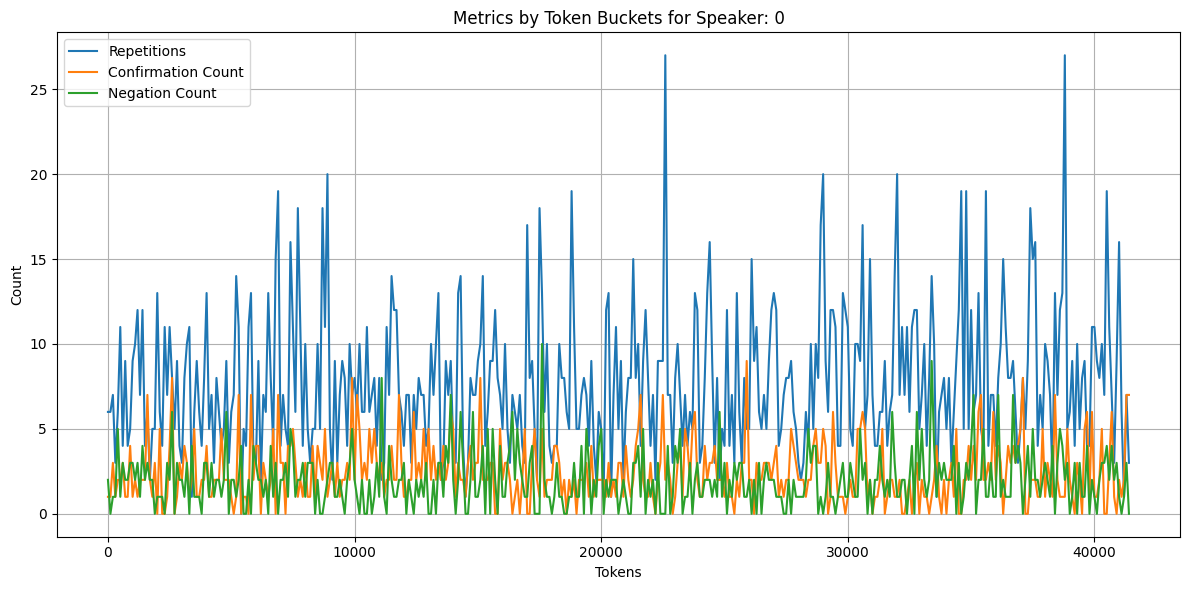

C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Tokens'] = all_tokens
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speaker_df['Token Size'] = token_sizes
C:\Users\Mohammad\AppData\Local\Temp\ipykernel_54704\902324663.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

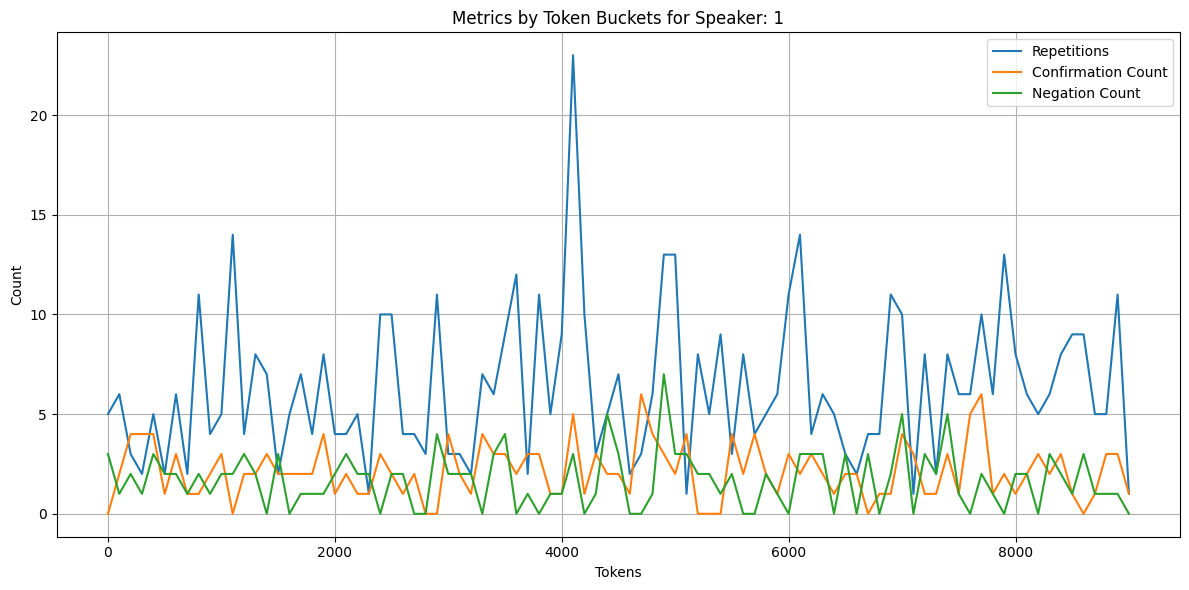

In [24]:
all_metrics = {}
all_personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in personality_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_metrics = pd.DataFrame(all_metrics).T

In [25]:
df_metrics

,Vocabulary Size,Total Tokens,Total Repetitions,Total Confirmations,Total Negations
0,4022,41430,3234,1011,821
1,1621,9018,576,194,154


# Task 5
In Task 5, we conduct a personality analysis by comparing each speaker’s language to predefined personality traits using doc2vec embeddings and cosine similarity. This approach enables us to quantify how each speaker’s language reflects the OCEAN personality model.

Step 1: Training the doc2vec Model
First, we train a doc2vec model on the dataset using each speaker's utterances. This model learns a high-dimensional embedding space, which we then use to generate a unique vector for each speaker by compiling all their utterances into a single document.

Step 2: Generating Personality Trait Embeddings
Using a predefined personality dictionary aligned with OCEAN traits, we calculate embeddings for each trait. Each trait is represented by two embeddings: one for the positive aspect (e.g., sociability for Extraversion) and one for the negative aspect (e.g., reclusiveness for Extraversion).

Step 3: Calculating Similarity Scores
To evaluate how closely each speaker aligns with each personality trait, we calculate cosine similarity between the speaker's embedding and the positive and negative embeddings for each trait. This similarity score provides an indication of each speaker’s alignment with both ends of the personality spectrum.

Step 4: Experimental Variations with Personality Dictionaries
To test the robustness of this approach, we conduct the analysis twice: once using a basic dictionary and once with an extended dictionary that includes additional related terms. By comparing the results, we assess how dictionary scope influences the accuracy and interpretability of the model’s personality predictions.

In [70]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Combine texts per speaker for training
combined_texts = {speaker: " ".join(speaker_df['Utterance_1'].tolist()) for speaker, speaker_df in speaker_dfs.items()}

# Prepare data for doc2vec
documents = [TaggedDocument(words=text.split(), tags=[speaker]) for speaker, text in combined_texts.items()]

# Train doc2vec model
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Function to generate embeddings using doc2vec
def generate_embedding(text):
    return model.infer_vector(text.split())

# Personality trait definitions with both sides of the spectrum (customizable)
personality_definitions = {
    'Extraversion': [('Talkative', 'Silent'), ('Sociable', 'Reclusive'), ('Adventurous', 'Cautious'), ('Open', 'Secretive')],
    'Agreeableness': [('Good-natured', 'Irritable'), ('Cooperative', 'Negativistic'), ('Mild', 'Headstrong'), ('Not jealous', 'Jealous')],
    'Conscientiousness': [('Responsible', 'Undependable'), ('Scrupulous', 'Unscrupulous'), ('Persevering', 'Quitting'), ('Fussy', 'Careless')],
    'Emotional Stability': [('Calm', 'Anxious'), ('Composed', 'Excitable'), ('Not hypochondriacal', 'Hypochondriacal'), ('Poised', 'Nervous')],
    'Openness': [('Intellectual', 'Unreflective'), ('Artistic', 'Non-artistic'), ('Imaginative', 'Simple'), ('Polished', 'Crude')],
}

# Generate embeddings for each side of each trait spectrum
personality_embeddings = {
    trait: [(generate_embedding(positive), generate_embedding(negative)) for positive, negative in pairs]
    for trait, pairs in personality_definitions.items()
}

# Function to compute the position on the spectrum for a trait
def compute_trait_position(dataframe_embedding, trait_embeddings):
    positions = []
    for pos_emb, neg_emb in trait_embeddings:
        pos_score = cosine_similarity([dataframe_embedding], [pos_emb])[0][0]
        neg_score = cosine_similarity([dataframe_embedding], [neg_emb])[0][0]
        position = pos_score -neg_score # Positive if closer to positive side, negative if closer to negative side
        positions.append(position)
    return np.mean(positions)  # Average position for the trait

# Compute and display results as a table for each speaker
import pandas as pd

# Initialize a dictionary to hold the trait positions for each speaker
table_data = {trait + '_Position': [] for trait in personality_definitions.keys()}
table_data['Speaker'] = []

# Process each speaker's text and compute positions on each trait
for speaker, text in combined_texts.items():
    embedding = generate_embedding(text)
    table_data['Speaker'].append(speaker)
    
    # Calculate the position for each trait
    for trait, trait_embeddings in personality_embeddings.items():
        position = compute_trait_position(embedding, trait_embeddings)
        table_data[f"{trait}_Position"].append(position)

# Convert to DataFrame and display
df = pd.DataFrame(table_data).set_index('Speaker')
df


,Extraversion_Position,Agreeableness_Position,Conscientiousness_Position,Emotional Stability_Position,Openness_Position
Speaker,,,,,
Chandler,0.134872,0.292325,0.027881,0.461259,0.043549
Joey,0.058173,0.273819,0.142548,0.355033,0.055920
Rachel,0.153598,0.289202,-0.001692,0.370390,0.133818
Monica,0.229919,0.271048,0.082158,0.419097,0.015916
Phoebe,0.185089,0.285770,0.092128,0.345483,0.048203
Ross,0.119575,0.292070,0.037228,0.437279,0.139358


In [71]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Combine texts per speaker for training
combined_texts = {speaker: " ".join(speaker_df['Utterance_1'].tolist()) for speaker, speaker_df in speaker_dfs.items()}

# Prepare data for doc2vec
documents = [TaggedDocument(words=text.split(), tags=[speaker]) for speaker, text in combined_texts.items()]

# Train doc2vec model
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

# Function to generate embeddings using doc2vec
def generate_embedding(text):
    return model.infer_vector(text.split())

# Personality trait definitions with both sides of the spectrum (customizable)
personality_definitions = {
    'Extraversion': [
        ('Talkative', 'Quiet'), 
        ('Outgoing', 'Reserved'), 
        ('Energetic', 'Lethargic'), 
        ('Expressive', 'Unexpressive'),
        ('Assertive', 'Submissive'),
        ('Friendly', 'Aloof'),
        ('Sociable', 'Withdrawn')
    ],
    'Agreeableness': [
        ('Friendly', 'Hostile'), 
        ('Cooperative', 'Uncooperative'), 
        ('Compassionate', 'Apathetic'), 
        ('Forgiving', 'Vindictive'),
        ('Trusting', 'Suspicious'),
        ('Generous', 'Selfish'),
        ('Tolerant', 'Intolerant')
    ],
    'Conscientiousness': [
        ('Organized', 'Disorganized'), 
        ('Dependable', 'Unreliable'), 
        ('Diligent', 'Lazy'), 
        ('Thorough', 'Negligent'),
        ('Self-disciplined', 'Impulsive'),
        ('Detail-oriented', 'Careless'),
        ('Goal-focused', 'Aimless')
    ],
    'Emotional Stability': [
        ('Calm', 'Anxious'), 
        ('Stable', 'Unstable'), 
        ('Confident', 'Insecure'), 
        ('Relaxed', 'Stressed'),
        ('Optimistic', 'Pessimistic'),
        ('Resilient', 'Vulnerable'),
        ('Content', 'Discontented')
    ],
    'Openness': [
        ('Curious', 'Indifferent'), 
        ('Inventive', 'Conventional'), 
        ('Insightful', 'Shallow'), 
        ('Broad-minded', 'Narrow-minded'),
        ('Artistic', 'Unimaginative'),
        ('Intellectually adventurous', 'Cautious'),
        ('Appreciative of diversity', 'Conforming')
    ]
}

# Generate embeddings for each side of each trait spectrum
personality_embeddings = {
    trait: [(generate_embedding(positive), generate_embedding(negative)) for positive, negative in pairs]
    for trait, pairs in personality_definitions.items()
}

# Function to compute the position on the spectrum for a trait
def compute_trait_position(dataframe_embedding, trait_embeddings):
    positions = []
    for pos_emb, neg_emb in trait_embeddings:
        pos_score = cosine_similarity([dataframe_embedding], [pos_emb])[0][0]
        neg_score = cosine_similarity([dataframe_embedding], [neg_emb])[0][0]
        position = pos_score -neg_score # Positive if closer to positive side, negative if closer to negative side
        positions.append(position)
    return np.mean(positions)  # Average position for the trait

# Compute and display results as a table for each speaker
import pandas as pd

# Initialize a dictionary to hold the trait positions for each speaker
table_data = {trait + '_Position': [] for trait in personality_definitions.keys()}
table_data['Speaker'] = []

# Process each speaker's text and compute positions on each trait
for speaker, text in combined_texts.items():
    embedding = generate_embedding(text)
    table_data['Speaker'].append(speaker)
    
    # Calculate the position for each trait
    for trait, trait_embeddings in personality_embeddings.items():
        position = compute_trait_position(embedding, trait_embeddings)
        table_data[f"{trait}_Position"].append(position)

# Convert to DataFrame and display
df = pd.DataFrame(table_data).set_index('Speaker')
df


,Extraversion_Position,Agreeableness_Position,Conscientiousness_Position,Emotional Stability_Position,Openness_Position
Speaker,,,,,
Chandler,0.104897,-0.001111,0.061788,0.041357,0.140063
Joey,0.018014,0.036505,0.055300,0.103585,0.082392
Rachel,0.079220,0.039728,0.027634,0.073352,0.147012
Monica,0.059888,0.059699,0.028668,0.027082,0.167761
Phoebe,0.023426,0.040363,0.046659,0.088690,0.136026
Ross,0.052614,0.047678,0.008740,0.079503,0.120281


In [ ]:
import pandas as pd
import ast  # To safely evaluate the string representation of lists

# Initialize a dictionary to store the speaker names and their personality traits
personality_data = {
    'Speaker': [],
    'Personality Trait 1': [],
    'Personality Trait 2': [],
    'Personality Trait 3': [],
    'Personality Trait 4': [],
    'Personality Trait 5': []
}

# Loop through each speaker and extract the values in the 'Personality' column
for speaker, speaker_df in speaker_dfs.items():
    # Check if 'Personality' is a column in the DataFrame
    if 'Personality' in speaker_df.columns and not speaker_df['Personality'].empty:
        # Get the first entry in the 'Personality' column
        first_personality_entry = speaker_df['Personality'].iloc[0]
        
        # Convert the string representation of the list to an actual list
        first_personality_list = ast.literal_eval(first_personality_entry)
        
        # Check if the entry is indeed a list and has the expected length
        if isinstance(first_personality_list, list) and len(first_personality_list) >= 5:
            personality_data['Speaker'].append(speaker)
            # Assign scores to their respective traits
            for i in range(5):  # Assuming we want the first 5 traits
                personality_data[f'Personality Trait {i + 1}'].append(first_personality_list[i])

# Convert the dictionary into a DataFrame for presentation
personality_df = pd.DataFrame(personality_data)

# Display the DataFrame
personality_df


,Speaker,Personality Trait 1,Personality Trait 2,Personality Trait 3,Personality Trait 4,Personality Trait 5
0,Chandler,0.648,0.375,0.386,0.580,0.477
1,Joey,0.574,0.614,0.297,0.545,0.455
2,Rachel,0.635,0.354,0.521,0.552,0.469
3,Monica,0.713,0.457,0.457,0.660,0.511
4,Phoebe,0.600,0.480,0.310,0.460,0.560
5,Ross,0.722,0.489,0.600,0.533,0.356
